In [1]:
import sys
import os
sys.path.append(os.path.abspath("Pytorch/"))
sys.path.append(os.path.abspath("models/"))

In [2]:
from FBSNNs import *
from ForwardContracts import *

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

M = 64  # number of trajectories (batch size)
N = 200 # number of time snapshots
D = 2 # number of dimensions
Mm = N ** (1/10)

layers = [D + 1] + 4 * [256] + [1]

Xi = np.array([0.5] * D)[None, :]
T = 1.0

"Available architectures"
mode = "NAIS-Net"  # FC, Resnet and NAIS-Net are available
activation = "Sine"  # Sine and ReLU are available
model = ForwardContracts(Xi, T, M, N, D, Mm, layers, mode, activation)

n_iter = 2*10**4
lr = 1e-3

In [5]:
model.load_model("models/ForwardsBasketUncorrelated.pth")

In [6]:
graph = model.iteration, model.training_loss

In [4]:
tot = time.time()
print(model.device)
graph = model.train(n_iter, lr)
print("total time:", time.time() - tot, "s")

cuda:0
It: 0, Loss: 1.785e+02, Y0: 0.831, Time: 0.38, Learning Rate: 1.000e-03
It: 100, Loss: 1.244e-03, Y0: 0.003, Time: 0.68, Learning Rate: 1.000e-03
It: 200, Loss: 5.098e-04, Y0: 0.000, Time: 0.67, Learning Rate: 1.000e-03
It: 300, Loss: 5.518e-04, Y0: 0.000, Time: 0.72, Learning Rate: 1.000e-03
It: 400, Loss: 4.762e-04, Y0: -0.000, Time: 0.65, Learning Rate: 1.000e-03
It: 500, Loss: 4.441e-04, Y0: -0.000, Time: 0.69, Learning Rate: 1.000e-03
It: 600, Loss: 4.058e-04, Y0: 0.000, Time: 0.67, Learning Rate: 1.000e-03
It: 700, Loss: 3.585e-04, Y0: 0.000, Time: 0.72, Learning Rate: 1.000e-03
It: 800, Loss: 4.009e-04, Y0: -0.000, Time: 0.73, Learning Rate: 1.000e-03
It: 900, Loss: 3.440e-04, Y0: 0.000, Time: 0.72, Learning Rate: 1.000e-03
It: 1000, Loss: 2.966e-04, Y0: -0.000, Time: 0.71, Learning Rate: 1.000e-03
It: 1100, Loss: 2.441e-04, Y0: 0.001, Time: 0.69, Learning Rate: 1.000e-03
It: 1200, Loss: 2.321e-04, Y0: -0.000, Time: 0.71, Learning Rate: 1.000e-03
It: 1300, Loss: 4.610e-04

In [7]:
t_test, W_test = model.fetch_minibatch()
X_pred, Y_pred = model.predict(Xi, t_test, W_test)

if type(t_test).__module__ != 'numpy':
    t_test = t_test.cpu().numpy()
if type(X_pred).__module__ != 'numpy':
    X_pred = X_pred.cpu().detach().numpy()
if type(Y_pred).__module__ != 'numpy':
    Y_pred = Y_pred.cpu().detach().numpy()

for i in range(63):
    t_test_i, W_test_i = model.fetch_minibatch()
    X_pred_i, Y_pred_i = model.predict(Xi, t_test_i, W_test_i)
    if type(X_pred_i).__module__ != 'numpy':
        X_pred_i = X_pred_i.cpu().detach().numpy()
    if type(Y_pred_i).__module__ != 'numpy':
        Y_pred_i = Y_pred_i.cpu().detach().numpy()
    X_pred = np.concatenate((X_pred, X_pred_i), axis=0)
    Y_pred = np.concatenate((Y_pred, Y_pred_i), axis=0)

if type(t_test).__module__ != 'numpy':
    t_test = t_test.cpu().numpy()
if type(X_pred).__module__ != 'numpy':
    X_pred = X_pred.cpu().detach().numpy()
if type(Y_pred).__module__ != 'numpy':
    Y_pred = Y_pred.cpu().detach().numpy()

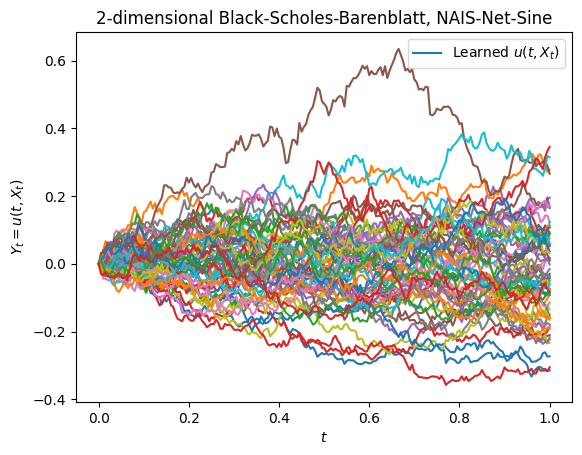

In [9]:
samples = 64

plt.figure()
plt.plot(t_test[0:1, :, 0].T, Y_pred[0:1, :, 0].T, label='Learned $u(t,X_t)$')


plt.plot(t_test[1:samples, :, 0].T, Y_pred[1:samples, :, 0].T)

plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.title(str(D) + '-dimensional Black-Scholes-Barenblatt, ' + model.mode + "-" + model.activation)
plt.legend()

plt.show()

In [6]:
X_preds = np.sum(X_pred, axis=2) - 1
X_preds.shape

(4096, 201)

In [8]:
Y_preds = Y_pred.reshape(4096,201)

In [9]:
time_stamps = t_test[0].reshape(201,)
time_stamps

array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
       0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
       0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
       0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265,
       0.27 , 0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 ,
       0.315, 0.32 , 0.325, 0.33 , 0.335, 0.34 , 0.345, 0.35 , 0.355,
       0.36 , 0.365, 0.37 , 0.375, 0.38 , 0.385, 0.39 , 0.395, 0.4  ,
       0.405, 0.41 , 0.415, 0.42 , 0.425, 0.43 , 0.435, 0.44 , 0.445,
       0.45 , 0.455, 0.46 , 0.465, 0.47 , 0.475, 0.48 , 0.485, 0.49 ,
       0.495, 0.5  , 0.505, 0.51 , 0.515, 0.52 , 0.525, 0.53 , 0.535,
       0.54 , 0.545, 0.55 , 0.555, 0.56 , 0.565, 0.57 , 0.575, 0.58 ,
       0.585, 0.59 , 0.595, 0.6  , 0.605, 0.61 , 0.615, 0.62 , 0.625,
       0.63 , 0.635,

In [12]:
epe = np.mean(np.maximum(Y_preds,0),axis=0)    
epe

array([0.00018675, 0.0052374 , 0.00735645, 0.00897037, 0.01040205,
       0.01163072, 0.01266337, 0.01355534, 0.01445611, 0.01523263,
       0.01613462, 0.01681095, 0.01764073, 0.01826842, 0.01869771,
       0.01956541, 0.02003893, 0.02054665, 0.02119499, 0.02190251,
       0.02232938, 0.02311939, 0.02385268, 0.024377  , 0.02497481,
       0.02518832, 0.02561055, 0.02619157, 0.02661496, 0.02692915,
       0.02739967, 0.02760108, 0.0279535 , 0.02846621, 0.02900785,
       0.02929282, 0.02987921, 0.03015974, 0.03073506, 0.03092521,
       0.03161118, 0.03230397, 0.03254158, 0.03308798, 0.03332385,
       0.03356904, 0.03375776, 0.03390996, 0.03445953, 0.03483449,
       0.03511296, 0.03520929, 0.03547031, 0.03588638, 0.03590929,
       0.03653606, 0.03667439, 0.03710041, 0.03736297, 0.03786862,
       0.03832193, 0.03860614, 0.03889333, 0.0392007 , 0.03952499,
       0.03964844, 0.03985558, 0.04015981, 0.04037856, 0.04073141,
       0.04074345, 0.04093407, 0.04125152, 0.04158971, 0.04160

In [11]:
ene = np.mean(np.minimum(Y_preds,0),axis=0)
ene

array([ 0.        , -0.00470012, -0.00669329, -0.00800002, -0.00920927,
       -0.01051758, -0.01154303, -0.01266892, -0.01349547, -0.01446118,
       -0.01528449, -0.0161264 , -0.01683891, -0.01741651, -0.01805909,
       -0.01864612, -0.01941944, -0.02005069, -0.02053892, -0.02132044,
       -0.0219106 , -0.02237533, -0.02287919, -0.02345095, -0.02411075,
       -0.02451277, -0.02496828, -0.02561105, -0.02591144, -0.02628543,
       -0.02678396, -0.02728662, -0.02802925, -0.02859011, -0.0290617 ,
       -0.02939584, -0.02983067, -0.03027577, -0.03070348, -0.03122601,
       -0.03158185, -0.03181385, -0.03212101, -0.03259386, -0.03311375,
       -0.03349235, -0.03375944, -0.03429687, -0.03488569, -0.03524885,
       -0.03570095, -0.03611797, -0.03644273, -0.03695716, -0.03750601,
       -0.0377338 , -0.03814641, -0.03854226, -0.03882009, -0.03906133,
       -0.03942461, -0.03975911, -0.04016162, -0.04029965, -0.04057553,
       -0.04101896, -0.04137871, -0.04178992, -0.04214874, -0.04

In [47]:
from scipy.stats import norm

In [48]:
rv = norm()

In [55]:
x_init = 0.5
strike = 0.5
sigma = 0.25

In [56]:
d1_1 = np.array([(-0 * s + np.log(x_init/strike) + (0+sigma**2/2)*s)/sigma/np.sqrt(s) 
            for s in time_stamps[1:]])
d2_1 = np.array([d1_1[i]-sigma*np.sqrt(s) for i,s in enumerate(time_stamps[1:])])

In [57]:
d1_2 = np.array([(-0 * s + np.log(x_init/strike) + (0+sigma**2/2)*s)/sigma/np.sqrt(s) 
            for s in time_stamps[1:]])
d2_2 = np.array([d1_2[i]-sigma*np.sqrt(s) for i,s in enumerate(time_stamps[1:])])

In [58]:
epe_exact = x_init*rv.cdf(d1_1) - strike*np.exp(-0)*rv.cdf(d2_1) + x_init*rv.cdf(d1_2) - strike*np.exp(-0)*rv.cdf(d2_2)
epe_exact

array([0.00493661, 0.00698135, 0.00855029, 0.00987293, 0.01103816,
       0.01209158, 0.01306027, 0.01396188, 0.01480866, 0.01560954,
       0.01637126, 0.01709906, 0.01779709, 0.01846873, 0.01911676,
       0.01974351, 0.02035094, 0.02094074, 0.02151435, 0.02207304,
       0.02261791, 0.02314994, 0.02367   , 0.02417885, 0.02467719,
       0.02516564, 0.02564478, 0.02611511, 0.02657709, 0.02703117,
       0.02747772, 0.02791712, 0.02834969, 0.02877574, 0.02919556,
       0.02960941, 0.03001753, 0.03042017, 0.03081753, 0.03120982,
       0.03159722, 0.03197991, 0.03235807, 0.03273184, 0.03310137,
       0.03346681, 0.03382829, 0.03418594, 0.03453987, 0.03489019,
       0.03523702, 0.03558044, 0.03592058, 0.03625751, 0.03659133,
       0.03692211, 0.03724994, 0.03757491, 0.03789707, 0.03821651,
       0.03853328, 0.03884746, 0.0391591 , 0.03946827, 0.03977504,
       0.04007943, 0.04038152, 0.04068136, 0.04097899, 0.04127446,
       0.04156782, 0.04185912, 0.04214839, 0.04243567, 0.04272

In [59]:
ene_exact = x_init*rv.cdf(-d1_1) - strike*np.exp(-0)*rv.cdf(-d2_1) + x_init*rv.cdf(-d1_2) - strike*np.exp(-0)*rv.cdf(-d2_2)
ene_exact

array([-0.00493661, -0.00698135, -0.00855029, -0.00987293, -0.01103816,
       -0.01209158, -0.01306027, -0.01396188, -0.01480866, -0.01560954,
       -0.01637126, -0.01709906, -0.01779709, -0.01846873, -0.01911676,
       -0.01974351, -0.02035094, -0.02094074, -0.02151435, -0.02207304,
       -0.02261791, -0.02314994, -0.02367   , -0.02417885, -0.02467719,
       -0.02516564, -0.02564478, -0.02611511, -0.02657709, -0.02703117,
       -0.02747772, -0.02791712, -0.02834969, -0.02877574, -0.02919556,
       -0.02960941, -0.03001753, -0.03042017, -0.03081753, -0.03120982,
       -0.03159722, -0.03197991, -0.03235807, -0.03273184, -0.03310137,
       -0.03346681, -0.03382829, -0.03418594, -0.03453987, -0.03489019,
       -0.03523702, -0.03558044, -0.03592058, -0.03625751, -0.03659133,
       -0.03692211, -0.03724994, -0.03757491, -0.03789707, -0.03821651,
       -0.03853328, -0.03884746, -0.0391591 , -0.03946827, -0.03977504,
       -0.04007943, -0.04038152, -0.04068136, -0.04097899, -0.04

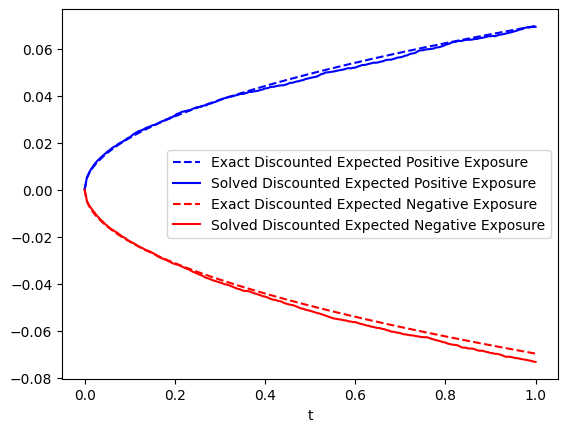

In [60]:
    fig = plt.figure()
    plt.plot(time_stamps,[0.0]+list(epe_exact),'b--',label='Exact Discounted Expected Positive Exposure')
    plt.plot(time_stamps,np.transpose(epe),'b',label='Solved Discounted Expected Positive Exposure' )

    plt.plot(time_stamps,[0.0]+list(ene_exact),'r--',label='Exact Discounted Expected Negative Exposure')
    plt.plot(time_stamps,np.transpose(ene),'r',label='Solved Discounted Expected Negative Exposure')

    plt.xlabel('t')
    plt.legend()

    plt.show()